In [1]:
# test the environment
import gym
env = gym.make('CarRacing-v0')

for i_episode in range(1):
    observation = env.reset()
    for t in range(200):
        env.render()
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

C:\Users\pierr\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Track generation: 1239..1553 -> 314-tiles track


In [2]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout
from keras.optimizers import Adam, sgd

import random
import numpy as np
from collections import deque

import pickle, os, gzip

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
state_size = env.observation_space.shape
processed_shape = (84,84,1)
new_shape = (1,)+state_size
new_processed_shape= (1,)+processed_shape
continuous_action_size = env.action_space.shape[0]
action_size = 4

print("State shape : " + str(state_size))
print("New shape : " + str(new_shape))
print("New prrocessed shape : " + str(new_processed_shape))
print("Continuous action shape : " + str(continuous_action_size))
print("Action shape : " + str(action_size))

State shape : (96, 96, 3)
New shape : (1, 96, 96, 3)
New prrocessed shape : (1, 84, 84, 1)
Continuous action shape : 3
Action shape : 4


In [4]:
def continuous_from_discrete(action):
    if (action==0):
        return [-1, 0, 0]
    if (action==1):
        return [1, 0, 0]
    if (action==2):
        return [0, 0, 0]
    #other actions to take into account [-1, 0, 0.5]  [1, 0, 0.5]  [0, 1, 0]  [0, 0, 0.5]
    return [0, 1, 0]

def discrete_from_continuous(action):
    if (action[0] == -1):
        return 0
    if (action[0] == 1):
        return 1
    if (action[1] == 0):
        return 2
    return 3

def onehot_from_discrete(action):
    return [ 1 if i==action else 0 for i in range(action_size)]

def discrete_from_onehot(onehot):
    for i in range(len(onehot)):
        if (onehot[i]==1):
            return i

In [530]:
discrete_from_onehot(onehot_from_discrete(2))

2

In [5]:
def preprocess(state):
    return np.reshape(state[:,:84,6:90,1], new_processed_shape)

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.0005
        self.model = self._build_model()

    def _build_model(self):
        # https://towardsdatascience.com/atari-reinforcement-learning-in-depth-part-1-ddqn-ceaa762a546f
        model = Sequential()
        model.add(Conv2D(filters = 32, kernel_size=8, strides=4, activation='relu', input_shape=processed_shape))
        model.add(Dropout(0.3))
        model.add(Conv2D(filters = 64, kernel_size=4, strides=2, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',metrics=['accuracy'], optimizer=Adam(lr=self.learning_rate))
        model.summary()
        return model

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        #if np.random.rand() <= self.epsilon:
        #    return random.randrange(self.action_size)
        state = preprocess(state)
        act_values = self.model.predict(state)[0]
        return np.argmax(act_values)  # returns action
    
    def in_grass(self, state):
        return state[0,82,42,1]>150

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = preprocess(state)
            next_state = preprocess(next_state)
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
    def train(self, memory):
        batch_size=100
        states = []
        target_fs = []
        minibatch = random.sample(memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = preprocess(state)
            next_state = preprocess(next_state)
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            states.append(state)
            target_fs.append(target_f)
        history = self.model.fit(np.array(states)[:,0,:,:,:],
                                 np.array(target_fs)[:,0,:],
                                 batch_size=batch_size,
                                 verbose=0)
        return history

    """
    # model and train for one hot encoding

    def _build_model(self):
        # https://towardsdatascience.com/atari-reinforcement-learning-in-depth-part-1-ddqn-ceaa762a546f
        model = Sequential()
        model.add(Conv2D(filters = 32, kernel_size=(8,8), strides=(4,4), activation='relu', input_shape=processed_shape))
        model.add(Dropout(0.3))
        model.add(Conv2D(filters = 64, kernel_size=(3,3), strides=(2,2), activation='relu'))
        model.add(Dropout(0.3))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dense(self.action_size, activation='softmax'))
        model.compile(loss='categorical_crossentropy',metrics=['accuracy'], optimizer=Adam(lr=self.learning_rate))
        model.summary()
        return model

    def train(self, memory):
        states = []
        actions = []
        for state, action, reward, next_state, done in memory:
            state = preprocess(state)
            action = onehot_from_discrete(action)
            states.append(state)
            actions.append([action])
        states = np.array(states)[:,0,:,:,:]
        actions = np.array(actions)[:,0,:]
        history = self.model.fit(states, actions, batch_size=100, epochs=100, validation_split=0.2)
        return history """

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

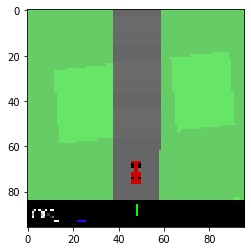

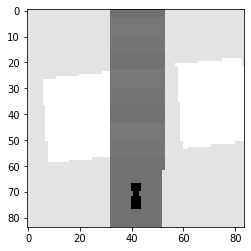

In [6]:
plt.imshow(observation)
plt.show()

plt.imshow(observation[:84,6:90,1] , cmap = plt.get_cmap('gray'))
plt.show()

In [7]:
done = False
warm_up = 50
batch_size = 100
EPISODES = 1000

In [534]:
def read_data():
    
    #get the data needed from the gzip
    print("Reading data...")
    with gzip.open('./data/data.pkl.gzip','rb') as f:
        data = pickle.load(f)
    states = data["state"]
    next_states = data["next_state"]
    actions = data["action"]
    rewards = data["reward"]
    dones = data["terminal"]
    
    # put it in the good format, as in the agent memory
    memory = deque(maxlen=100000)
    NB_TRIALS = len(states)
    for ii in range(NB_TRIALS):
        for jj in range(warm_up,len(states[ii])):
            state = states[ii][jj]
            state = np.reshape(state, new_shape)
            action = discrete_from_continuous(actions[ii][jj])
            reward = rewards[ii][jj]
            next_state = next_states[ii][jj]
            next_state = np.reshape(next_state, new_shape)
            done = dones[ii][jj]
            memory.append((state, action, reward, next_state, done))
    
    return memory

In [8]:
agent = DQNAgent(state_size, action_size)

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 20, 32)        2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
dropout_2 (Dropout)          (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5184)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               663680    
________________________________________________

In [538]:
train_memory = read_data()

histories = []
print("Training...")
for ii in range(1000):
    history = agent.train(train_memory)
    if ii%10 == 9:
        histories.append(history)
        print("----------- " +str(ii+1)+"/1000"+ " ------ val_loss : "+str(history.history['accuracy']))
print("Complete")

"""
train_memory = read_data()
history = agent.train(train_memory)
"""

Reading data...
Training...
----------- 10/1000 ------ val_loss : [0.32]
----------- 20/1000 ------ val_loss : [0.39]
----------- 30/1000 ------ val_loss : [0.38]
----------- 40/1000 ------ val_loss : [0.35]
----------- 50/1000 ------ val_loss : [0.45]
----------- 60/1000 ------ val_loss : [0.82]
----------- 70/1000 ------ val_loss : [0.86]
----------- 80/1000 ------ val_loss : [0.37]
----------- 90/1000 ------ val_loss : [0.61]
----------- 100/1000 ------ val_loss : [0.6]
----------- 110/1000 ------ val_loss : [0.44]
----------- 120/1000 ------ val_loss : [0.36]
----------- 130/1000 ------ val_loss : [0.39]
----------- 140/1000 ------ val_loss : [0.35]
----------- 150/1000 ------ val_loss : [0.44]
----------- 160/1000 ------ val_loss : [0.43]
----------- 170/1000 ------ val_loss : [0.7]
----------- 180/1000 ------ val_loss : [0.78]
----------- 190/1000 ------ val_loss : [0.69]
----------- 200/1000 ------ val_loss : [0.86]
----------- 210/1000 ------ val_loss : [0.84]
----------- 220/1

'\ntrain_memory = read_data()\nhistory = agent.train(train_memory)\n'

In [9]:
agent.load("dqn_imitation_learning_v1.h5")

In [20]:
# test the agent on the environment

for e in range(EPISODES):
    state = env.reset()
    state = np.reshape(state, new_shape)
    for time in range(1000):
        env.render()
        action = agent.act(state) if (time>warm_up) else 3
        next_state, reward, done, _ = env.step(continuous_from_discrete(action))
        next_state = np.reshape(next_state, new_shape)
        #if agent.in_grass(next_state) and time>warm_up:
        #    done = True
        state = next_state
        if done:
            print("episode: {}/{}, score: {}, e: {:.2}"
                  .format(e, EPISODES, time, agent.epsilon))
            break

Track generation: 1079..1354 -> 275-tiles track


GLException: b'op\xe9ration non valide'

In [21]:
agent.load("dqn_imitation_learning_v1.h5")

In [14]:
EPISODES = 100
for e in range(EPISODES):
    state = env.reset()
    state = np.reshape(state, new_shape)
    for time in range(1000):
        action = agent.act(state) if (time>warm_up) else 3
        next_state, reward, done, _ = env.step(continuous_from_discrete(action))
        reward = reward if not done else -10
        next_state = np.reshape(next_state, new_shape)
        agent.memorize(state, action, reward, next_state, done)
        state = next_state
        if done:
            print("episode: {}/{}, score: {}, e: {:.2}"
                  .format(e, EPISODES, time, agent.epsilon))
            break
    if len(agent.memory) > batch_size:
        agent.replay(batch_size)
            
agent.save("dqn_imitation_learning_v2.h5")

Track generation: 1078..1355 -> 277-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1223..1533 -> 310-tiles track
episode: 0/100, score: 953, e: 1.0
Instructions for updating:
Use tf.cast instead.
Track generation: 1086..1371 -> 285-tiles track
episode: 1/100, score: 999, e: 0.99
Track generation: 1182..1482 -> 300-tiles track
episode: 2/100, score: 999, e: 0.99
Track generation: 1098..1376 -> 278-tiles track
episode: 3/100, score: 999, e: 0.99
Track generation: 1212..1519 -> 307-tiles track
episode: 4/100, score: 547, e: 0.98
Track generation: 1072..1349 -> 277-tiles track
episode: 5/100, score: 428, e: 0.98
Track generation: 1143..1433 -> 290-tiles track
episode: 6/100, score: 388, e: 0.97
Track generation: 1204..1509 -> 305-tiles track
episode: 7/100, score: 357, e: 0.97
Track generation: 1067..1338 -> 271-tiles track
episode: 8/100, score: 379, e: 0.96
Track generation: 1131..1418 -> 287-tiles track
episode: 9/100, score: 375, e

episode: 86/100, score: 375, e: 0.65
Track generation: 1132..1419 -> 287-tiles track
episode: 87/100, score: 999, e: 0.65
Track generation: 1115..1398 -> 283-tiles track
episode: 88/100, score: 376, e: 0.64
Track generation: 1099..1378 -> 279-tiles track
episode: 89/100, score: 375, e: 0.64
Track generation: 1040..1311 -> 271-tiles track
episode: 90/100, score: 173, e: 0.64
Track generation: 1134..1428 -> 294-tiles track
episode: 91/100, score: 239, e: 0.63
Track generation: 1183..1483 -> 300-tiles track
episode: 92/100, score: 376, e: 0.63
Track generation: 1116..1406 -> 290-tiles track
episode: 93/100, score: 178, e: 0.63
Track generation: 1223..1533 -> 310-tiles track
episode: 94/100, score: 999, e: 0.62
Track generation: 1253..1570 -> 317-tiles track
episode: 95/100, score: 999, e: 0.62
Track generation: 1076..1355 -> 279-tiles track
episode: 96/100, score: 231, e: 0.62
Track generation: 1255..1573 -> 318-tiles track
episode: 97/100, score: 380, e: 0.61
Track generation: 1087..1363

In [107]:
test.shape

(84, 96)

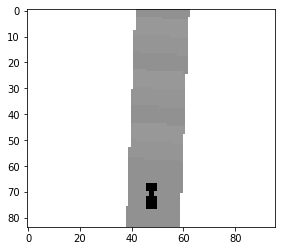

In [106]:
%matplotlib inline 
plt.imshow(test, cmap = plt.get_cmap('gray'))
plt.show()

In [13]:
action

array([0.80701834, 0.01145028, 0.3124179 ], dtype=float32)

In [16]:
env.action_space.sample()

array([-0.8295293 ,  0.49595413,  0.3533085 ], dtype=float32)

In [22]:
env.close()